Multigrid Predictive Filter Flow for Unsupervised Video Segmentation
================
**Author**: `Shu Kong <https://www.ics.uci.edu/~skong2/>`

**Date**: April 2019

**Project Page**: [website](https://www.ics.uci.edu/~skong2/mgpff.html)

**Highlights**: 
-  training from scratch on a single GPU;
-  unsupervised learning on free-form videos;
-  the un-optimized model is extremely compact (4.6MB);
-  fast processing -- wall-clock time for processing a pair of 256x256 frames is 0.1 second.

import packages
------------------

Some packages are installed automatically if you use Anaconda. As pytorch is used here, you are expected to install that in your machine. 

In [1]:
from __future__ import print_function, division
import os, random, time, copy
from skimage import io, transform, measure, filters
import numpy as np
import os.path as path
import scipy.io as sio
from scipy import misc
from scipy import ndimage, signal
import scipy
import pickle
import sys
import math
import matplotlib.pyplot as plt
import PIL.Image
from io import BytesIO
from skimage import data, img_as_float
from skimage.measure import compare_ssim as ssim
from skimage.measure import compare_psnr as psnr

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler 
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms

sys.path.append('/home/skong2/project/dpff4ldl')
from libs.utils.metrics import *
from libs.utils.metrics import *
from libs.utils.flow_functions import *
#from models.pem import *
from libs.models.PEM_compact import *

from libs.fetchData.datasetCOMBINED import *
from libs.fetchData.datasetCOMBINED_testing import *
from libs.fetchData.datasetDAVIS_MultiScaleFramePair_ResizeOnTheFly import *
from libs.trainingProtocol.trainval_COM2s_msLoss import *
from libs.losses import *

import warnings # ignore warnings
warnings.filterwarnings("ignore")
print(sys.version)
print(torch.__version__)

3.6.5 |Anaconda, Inc.| (default, Apr 29 2018, 16:14:56) 
[GCC 7.2.0]
0.4.1


Setup config parameters
 -----------------
 
 There are several things to setup, like which GPU to use, where to read images and save files, etc. Please read and understand this. By default, you should be able to run this script smoothly by changing nothing.

In [2]:
# set device, which gpu to use.
device ='cpu'
supplDevice = 'cpu'
if torch.cuda.is_available(): 
    device='cuda:0'
    supplDevice='cuda:0'

################## set attributes for this project/experiment ##################
# config result folder
exp_dir = './exp' # experiment directory, used for reading the init model
project_name = 'main0014_COMTiny4s_v1_k11fvr1sm1o3grad0001_512x512_msLoss'

path_to_root = ['./data/DAVIS_videos']



downsizeFactorList = [1/2., 1/4., 1/8., 1/16., 1/32.] # [1,1/2.,1/4.,1/8.,1/16.,1/32.]
#cropSize = [384, 768] # patch size for training the model
#cropSize = [256, 256] # patch size for training the model
cropSize = [512, 512] # patch size for training the model


gapFrameNumber = 10
saveFigures = True


batch_size = 3
#weight4SparsityLoss = 0
dilateRate = 1
weight4FilterSmoothLoss = 1
weight4GradientDifferenceLoss = 0.001
weight4FlowVectorReconstructionLoss = 1
maxRangePixel = 3


embedding_dim = 16 # dimension of the learned embedding space
kernel_size = 11
lambda_norm = 0.1
total_epoch_num = 1000 # total number of epoch in training
base_lr = 0.001 # base learning rate


torch.cuda.device_count()
torch.cuda.empty_cache()

save_dir = os.path.join(exp_dir, project_name)
print(save_dir)    
if not os.path.exists(save_dir): os.makedirs(save_dir)

log_filename = os.path.join(save_dir, 'train.log')

TFNormalize = transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))

./exp/main0014_COMTiny4s_v1_k11fvr1sm1o3grad0001_512x512_msLoss


Define model architecture
---------

Here is the definition of the model architecture. 

In [3]:
class SiamesePixelEmbed(nn.Module):
    def __init__(self, emb_dimension=32, filterSize=11, device='cpu', pretrained=False):
        super(SiamesePixelEmbed, self).__init__()
        self.device = device
        self.emb_dimension = emb_dimension  
        #self.PEMbase = PixEmbedResTiny(emb_dimension=self.emb_dimension, pretrained=pretrained) 
        self.PEMbase = MultigridPFF_tiny(emb_dimension=self.emb_dimension) 
        
        self.rawEmbFeature1 = 0
        self.rawEmbFeature2 = 0        
        self.embFeature1_to_2 = 0
        self.embFeature1_to_2 = 0
        self.filterSize = filterSize
        self.filterSize2Channel = self.filterSize**2
                
        self.ordered_embedding = nn.Sequential(            
            nn.Conv2d(self.emb_dimension*2, self.filterSize2Channel, kernel_size=3, 
                      dilation=1, padding=1, bias=False),
            nn.BatchNorm2d(self.filterSize2Channel, momentum=0.001),     
            nn.ReLU(True),
            nn.Conv2d(self.filterSize2Channel, self.filterSize2Channel, kernel_size=3, 
                      dilation=1, padding=1, bias=False),
            nn.BatchNorm2d(self.filterSize2Channel, momentum=0.001),     
            nn.ReLU(True),
            nn.Conv2d(self.filterSize2Channel, self.filterSize2Channel, kernel_size=3, 
                      padding=1, bias=False),
            nn.BatchNorm2d(self.filterSize2Channel, momentum=0.001),  
            nn.ReLU(True),          
            nn.Conv2d(self.filterSize2Channel, self.filterSize2Channel, kernel_size=3,
                      padding=1, bias=True)
        )
        
        
    def forward(self, inputs1, inputs2): 
        self.rawEmbFeature1 = self.PEMbase.forward(inputs1)
        self.rawEmbFeature2 = self.PEMbase.forward(inputs2)
        
        img1_to_img2 = torch.cat([self.rawEmbFeature1, self.rawEmbFeature2], 1)
        img2_to_img1 = torch.cat([self.rawEmbFeature2, self.rawEmbFeature1], 1)
        
        self.embFeature1_to_2 = self.ordered_embedding(img1_to_img2)        
        self.embFeature1_to_2 = F.softmax(self.embFeature1_to_2, 1)
        
        self.embFeature2_to_1 = self.ordered_embedding(img2_to_img1)
        self.embFeature2_to_1 = F.softmax(self.embFeature2_to_1, 1)
        
        return self.embFeature2_to_1, self.embFeature1_to_2    

def genFlowVector4Visualization(F_fine2coarse):
    F1tmp = F_fine2coarse[0]
    H,W = F1tmp.shape[1:]

    maxvalXMask = torch.ones(1,1)*(W-1)
    maxvalXMask = maxvalXMask.repeat(H,W)#.to(device)
    maxvalYMask = torch.ones(1,1)*(H-1)
    maxvalYMask = maxvalYMask.repeat(H,W)#.to(device)
    minvalMask = torch.zeros(1,1)
    minvalMask = minvalMask.repeat(H,W)#.to(device)


    UV = torch.zeros_like(F1tmp)
    grid_x = torch.arange(0, W).view(1,-1).repeat(H,1).float() #.to(device)
    grid_y = torch.arange(0, H).view(-1,1).repeat(1,W).float() #.to(device)
    #ylist, xlist = grid_y.numpy(), grid_x.numpy()
    ycoord, xcoord = grid_y, grid_x
    for i, Fvec in enumerate(F_fine2coarse):    
        xcoord_round = torch.round(xcoord)
        xcoord_round = clipTensor(xcoord_round,maxvalXMask,minvalMask)
        ycoord_round = torch.round(ycoord)
        ycoord_round = clipTensor(ycoord_round,maxvalYMask,minvalMask)
        xcoord_ceil = torch.ceil(xcoord)
        xcoord_ceil = clipTensor(xcoord_ceil,maxvalXMask,minvalMask)
        xcoord_floor = torch.floor(xcoord)
        xcoord_floor = clipTensor(xcoord_floor,maxvalXMask,minvalMask)
        ycoord_ceil = torch.ceil(ycoord)
        ycoord_ceil = clipTensor(ycoord_ceil,maxvalYMask,minvalMask)
        ycoord_floor = torch.floor(ycoord)
        ycoord_floor = clipTensor(ycoord_floor,maxvalYMask,minvalMask)


        xcoord_round = xcoord_round.detach().cpu().numpy()
        ycoord_round = ycoord_round.detach().cpu().numpy()      
        xcoord_ceil = xcoord_ceil.detach().cpu().numpy()
        xcoord_floor = xcoord_floor.detach().cpu().numpy()
        ycoord_ceil = ycoord_ceil.detach().cpu().numpy()
        ycoord_floor = ycoord_floor.detach().cpu().numpy()        


        xlist_supp_round, ylist_supp_round = Fvec[0,ycoord_round,xcoord_round], Fvec[1,ycoord_round,xcoord_round] 
        xlist_supp_UL, ylist_supp_UL = Fvec[0,ycoord_floor,xcoord_floor], Fvec[1,ycoord_floor,xcoord_floor] 
        xlist_supp_UR, ylist_supp_UR = Fvec[0,ycoord_floor,xcoord_ceil], Fvec[1,ycoord_floor,xcoord_ceil] 
        xlist_supp_BL, ylist_supp_BL = Fvec[0,ycoord_ceil,xcoord_floor], Fvec[1,ycoord_ceil,xcoord_floor] 
        xlist_supp_BR, ylist_supp_BR = Fvec[0,ycoord_ceil,xcoord_ceil], Fvec[1,ycoord_ceil,xcoord_ceil] 

        xcoord_ceil = torch.from_numpy(xcoord_ceil)
        xcoord_floor = torch.from_numpy(xcoord_floor)
        ycoord_ceil = torch.from_numpy(ycoord_ceil)
        ycoord_floor = torch.from_numpy(ycoord_floor)


        dominatorTMP = xcoord_ceil-xcoord_floor
        dominatorTMP[dominatorTMP==0]=1
        wLeft = xcoord_ceil-xcoord
        wRight = xcoord-xcoord_floor
        wLeft[wLeft==0]=0.5
        wRight[wRight==0]=0.5

        xlist_supp_u = wLeft/dominatorTMP*xlist_supp_UL + wRight/dominatorTMP*xlist_supp_UR 
        xlist_supp_b = wLeft/dominatorTMP*xlist_supp_BL + wRight/dominatorTMP*xlist_supp_BR 

        dominatorTMP = ycoord_ceil-ycoord_floor
        dominatorTMP[dominatorTMP==0]=1
        wUpper = ycoord_ceil-ycoord
        wBottom = ycoord-ycoord_floor
        wUpper[wUpper==0]=0.5
        wBottom[wBottom==0]=0.5
        xlist_supp =  wUpper/dominatorTMP*xlist_supp_u + wBottom/dominatorTMP*xlist_supp_b


        dominatorTMP = xcoord_ceil-xcoord_floor
        dominatorTMP[dominatorTMP==0]=1
        wLeft = xcoord_ceil-xcoord
        wRight = xcoord-xcoord_floor
        wLeft[wLeft==0]=0.5
        wRight[wRight==0]=0.5

        ylist_supp_u = wLeft/dominatorTMP*ylist_supp_UL + wRight/dominatorTMP*ylist_supp_UR 
        ylist_supp_b = wLeft/dominatorTMP*ylist_supp_BL + wRight/dominatorTMP*ylist_supp_BR 

        dominatorTMP = ycoord_ceil-ycoord_floor
        dominatorTMP[dominatorTMP==0]=1
        wUpper = ycoord_ceil-ycoord
        wBottom = ycoord-ycoord_floor
        wUpper[wUpper==0]=0.5
        wBottom[wBottom==0]=0.5
        ylist_supp =  wUpper/dominatorTMP*ylist_supp_u + wBottom/dominatorTMP*ylist_supp_b


        if i==len(F_fine2coarse)-1:
            xlist_supp, ylist_supp = xlist_supp_round, ylist_supp_round
            #xlist, ylist = xcoord-grid_x.detach().cpu(), ycoord-grid_y.detach().cpu()
            #xlist, ylist = torch.round(xlist), torch.round(ylist)

        xcoord, ycoord = xlist_supp+xcoord, ylist_supp+ycoord
        xcoord = xcoord.detach().cpu()#.numpy()
        ycoord = ycoord.detach().cpu()#.numpy()
        
        if i==len(F_fine2coarse)-1:
            xlist, ylist = xcoord-grid_x.detach().cpu(), ycoord-grid_y.detach().cpu()

    UV[0] = xlist.view(1,H,W)
    UV[1] = ylist.view(1,H,W)
    return UV

def clipTensor(X, maxMask, minMask):
    X = torch.min(X,maxMask)    
    X = torch.max(X,minMask)    
    return X

def funcOpticalFlowWarp(x, flo, device='cpu'):
    """
    warp an image/tensor (im2) back to im1, according to the optical flow
    x: [B, C, H, W] (im2)
    flo: [B, 2, H, W] flow
    """
    B, C, H, W = x.size()
    # mesh grid 
    xx = torch.arange(0, W).view(1,-1).repeat(H,1)
    yy = torch.arange(0, H).view(-1,1).repeat(1,W)
    xx = xx.view(1,1,H,W).repeat(B,1,1,1)
    yy = yy.view(1,1,H,W).repeat(B,1,1,1)
    grid = torch.cat((xx,yy),1).float()
    grid = grid.to(device)
    vgrid = Variable(grid).to(device) + flo.to(device)

    # scale grid to [-1,1] 
    vgrid[:,0,:,:] = 2.0*vgrid[:,0,:,:]/max(W-1,1)-1.0
    vgrid[:,1,:,:] = 2.0*vgrid[:,1,:,:]/max(H-1,1)-1.0
    vgrid = vgrid.permute(0,2,3,1)        
    output = nn.functional.grid_sample(x, vgrid)
    mask = torch.autograd.Variable(torch.ones(x.size())).to(device)
    mask = F.grid_sample(mask.to(device), vgrid.to(device))

    mask[mask<0.9999] = 0
    mask[mask>0] = 1
    return output*mask, mask

evaluation/testing demo
-----------
##### load a pretrained model

In [4]:
################## load model ###################
path_to_save_paramOnly = './exp/main1002_DAVIS_recFocus_v2_intFlow_bidir/epoch-30.paramOnly' # 6.8794937

print(path_to_save_paramOnly)
curmodel = SiamesePixelEmbed(emb_dimension=embedding_dim, 
                             filterSize=kernel_size,
                             device=device, pretrained=False)
curmodel.load_state_dict(torch.load(path_to_save_paramOnly))
curmodel.to(device);    
#print(curmodel.state_dict)
curmodel.eval()
#curmodel.train()
curmodel.training = False
print(curmodel.training)

./exp/main1002_DAVIS_recFocus_v2_intFlow_bidir/epoch-30.paramOnly
False


##### evaluating/testing on novel images, returning quantitative results

In [5]:
################## evaluate over validation set ###################
#eval_model(curmodel, dataloaders, dataset_sizes, criterion, device=device)
loss_warp4reconstruction = Loss4GridSamplingWithFlowVecOffsetByFilterFlow(
    device=device, weight=weight4FlowVectorReconstructionLoss)
loss_pixelReconstruction = Loss4RobustPixelReconstruction(device=device, filterSize=kernel_size)
loss_pixelReconstructionX2 = Loss4RobustPixelReconstruction(device=device, filterSize=kernel_size*2)
loss_pixelReconstructionX4 = Loss4RobustPixelReconstruction(device=device, filterSize=kernel_size*4)
loss_pixelReconstructionX8 = Loss4RobustPixelReconstruction(device=device, filterSize=kernel_size*8)
loss_pixelReconstructionX16 = Loss4RobustPixelReconstruction(device=device, filterSize=kernel_size*16)
loss_pixelReconstructionX32 = Loss4RobustPixelReconstruction(device=device, filterSize=kernel_size*32)

warpImgWithScale32 = WarpImageByGridSamplingWithFlowVec(device=device, scale=32)
warpImgWithScale16 = WarpImageByGridSamplingWithFlowVec(device=device, scale=16)
warpImgWithScale8 = WarpImageByGridSamplingWithFlowVec(device=device, scale=8)
warpImgWithScale4 = WarpImageByGridSamplingWithFlowVec(device=device, scale=4)
warpImgWithScale2 = WarpImageByGridSamplingWithFlowVec(device=device, scale=2)
warpImgWithScale1 = WarpImageByGridSamplingWithFlowVec(device=device, scale=1)

visualize pixel embedding
--------

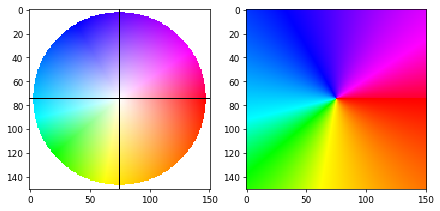

In [6]:
objDemoShowFlow = DemoShowFlow() # height=int(Y.max()), width=int(Y.max())


figWinNumHeight, figWinNumWidth = 1, 2
plt.figure(figsize=(figWinNumWidth*4,figWinNumHeight*4), dpi=64, facecolor='w', edgecolor='k') # figsize -- inch-by-inch
plt.clf()
subwinCount = 1   

plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
plt.imshow(objDemoShowFlow.FlowColorChart)

plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
plt.imshow(objDemoShowFlow.FlowColorChartNoAxes)

#misc.imsave(os.path.join(save_dir, 'colorchar.png'.format(idx)), objDemoShowFlow.FlowColorChart*255, format='png')

In [8]:
set_name = 'val'
videoname = 'longboard'# 'dog blackswan bear soccerball bike-packing  car-race
path_to_root = './data/DAVIS_videos/'+videoname
path_to_mask = './data/masks/'+videoname+'/00000.png'


objIdx = 1
postscript = '_obj{:d}'.format(objIdx)



save_dir = os.path.join('./vis_frameRecGap{}'.format(gapFrameNumber), videoname+postscript)
print(save_dir)    
if not os.path.exists(save_dir): os.makedirs(save_dir)


testset = VideoClip4Testing(root_dir=path_to_root,  
                            set_name=set_name, 
                            downsizeFactorList=downsizeFactorList,
                            size=cropSize, #  if set_name=='train' else [-1,-1]
                            TFNormalize=TFNormalize)


dataloader4videoseg = DataLoader(testset, #whole_datasets[setname],  # val train
                                 batch_size=gapFrameNumber,
                                 shuffle=False, #set_name=='train',  # False True
                                 num_workers=1) # num_work can be set to batch_size  
print(len(dataloader4videoseg))

TF2tensor = transforms.ToTensor()
TFresize = transforms.Resize((int(512/2),int(512/2)))
#downsizeFactorList = [1/2., 1/4., 1/8., 1/16.]
#cropSize = [384, 768]
                     
    
    
mask = PIL.Image.open(path_to_mask)
#mask = misc.imread(path_to_mask)
#mask = mask.astype(np.float32) 
mask = TFresize(mask)
mask = TF2tensor(mask)
mask = mask/mask.max()
objIdxList = mask.unique().sort()[0].cpu().numpy()
print('\nthere are',len(objIdxList)-1, 'object(s)\n')
mask = mask.squeeze().numpy()
objID = objIdxList[objIdx]
#mask = ndimage.binary_erosion(mask, structure=np.ones((3,3))).astype(mask.dtype)
mask = torch.from_numpy(mask)
print(mask.shape, mask.max(), mask.min())
mask_raw = mask.squeeze()
mask = mask.cpu().numpy()==objID
mask = mask.astype(np.float32)
mask_gt = mask.squeeze()




mask = PIL.Image.open(path_to_mask)
mask = TFresize(mask)
mask = TF2tensor(mask)
mask = mask/mask.max()
objIdxList = mask.unique().sort()[0].cpu().numpy()
mask = mask.squeeze().numpy()
objID = objIdxList[objIdx]
mask = mask==objID
#mask = mask.type(torch.float)
mask = mask.astype(np.float32)
mask_erode = ndimage.binary_erosion(mask, structure=np.ones((3,3))).astype(mask.dtype)
mask_erode = torch.from_numpy(mask_erode)
mask_erode = mask_erode.squeeze().unsqueeze(0).unsqueeze(0)
#mask = mask/mask.max()
mask_erode = mask_erode.squeeze()

mask_init = mask_erode.squeeze().unsqueeze(0).unsqueeze(0)

mask_dilate = ndimage.binary_dilation(mask, structure=np.ones((3,3))).astype(mask.dtype)
mask_dilate = torch.from_numpy(mask_dilate)
mask_dilate = mask_dilate.squeeze().unsqueeze(0).unsqueeze(0)
#mask = mask/mask.max()
mask_dilate = mask_dilate.squeeze()


sample = iter(dataloader4videoseg).next()
imgListA2,imgListB2,imgListA4,imgListB4,imgListA8,imgListB8 = sample[:6]
imgListA16,imgListB16,imgListA32,imgListB32 = sample[6:]

./vis_frameRecGap10/longboard_obj1
6

there are 5 object(s)

torch.Size([256, 256]) tensor(1.) tensor(0.)


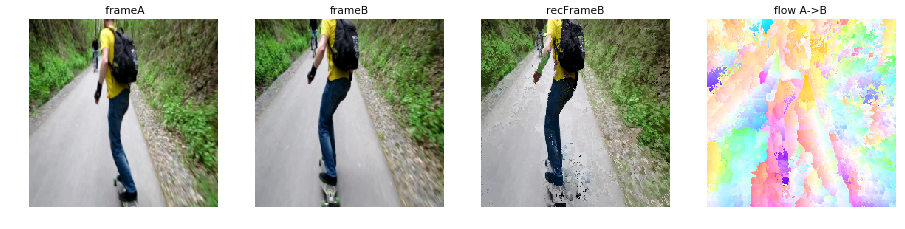

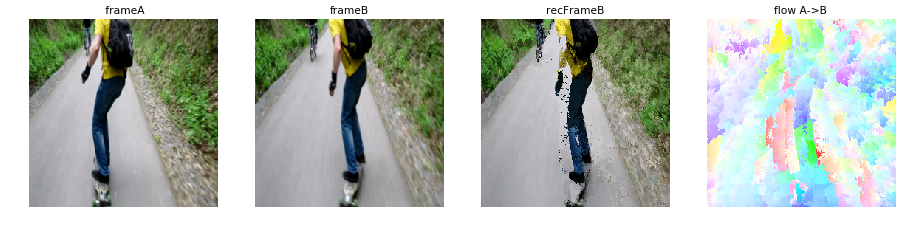

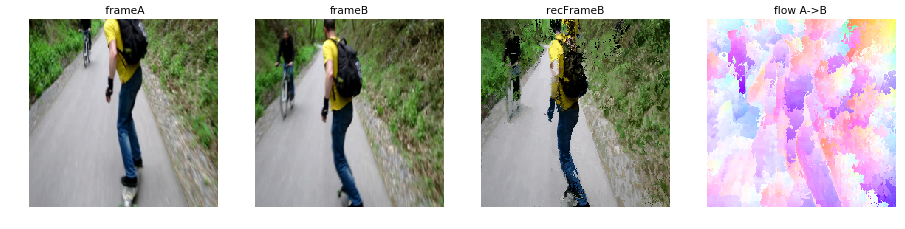

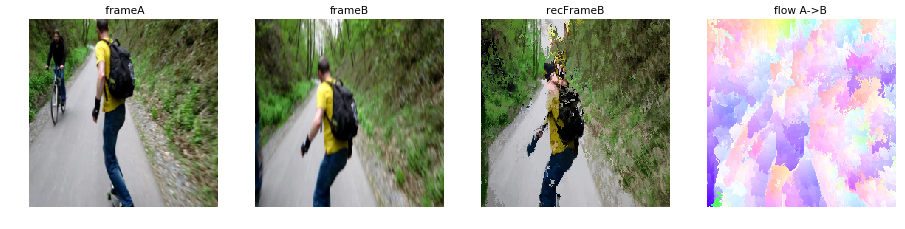

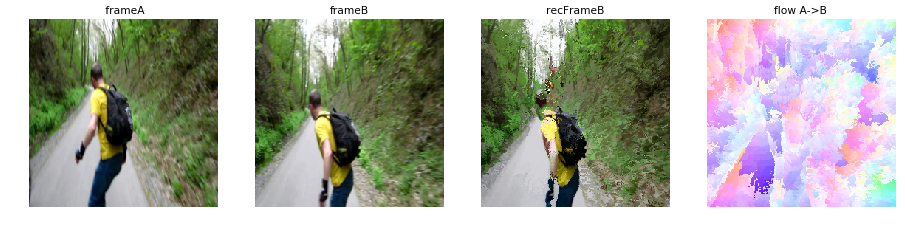

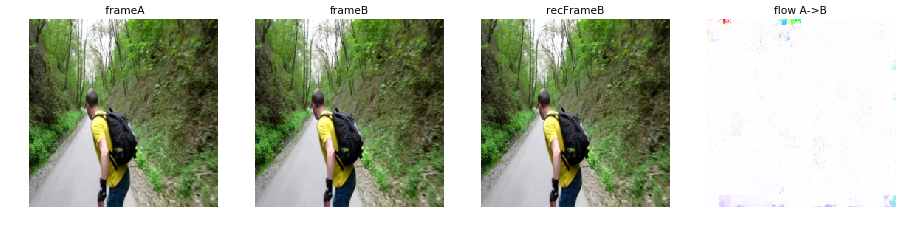

In [9]:
sampler = iter(dataloader4videoseg)
recErrorList = []
for i, sample in enumerate(sampler):
    ################## visualize some samples ###################
    imgListA2,imgListB2,imgListA4,imgListB4,imgListA8,imgListB8 = sample[:6]
    imgListA16,imgListB16,imgListA32,imgListB32 = sample[6:]
    
    imgListB2 = imgListA2[-1].unsqueeze(0)
    imgListA2 = imgListA2[0].unsqueeze(0)
    imgListB4 = imgListA4[-1].unsqueeze(0)
    imgListA4 = imgListA4[0].unsqueeze(0)
    imgListB8 = imgListA8[-1].unsqueeze(0)
    imgListA8 = imgListA8[0].unsqueeze(0)
    imgListB16 = imgListA16[-1].unsqueeze(0)
    imgListA16 = imgListA16[0].unsqueeze(0)
    imgListB32 = imgListA32[-1].unsqueeze(0)
    imgListA32 = imgListA32[0].unsqueeze(0)
    
        
        
    imgListA2 = imgListA2.to(device)
    imgListB2 = imgListB2.to(device)
    imgListA4 = imgListA4.to(device)
    imgListB4 = imgListB4.to(device)
    imgListA8 = imgListA8.to(device)
    imgListB8 = imgListB8.to(device)
    imgListA16 = imgListA16.to(device)
    imgListB16 = imgListB16.to(device)
    imgListA32 = imgListA32.to(device)
    imgListB32 = imgListB32.to(device)
    
    if True:   
        warpImgWithScale16.device = device 
        warpImgWithScale8.device = device 
        warpImgWithScale4.device = device 
        warpImgWithScale2.device = device 
        warpImgWithScale1.device = device 
        
            
        _, PFFx32_1to2 = curmodel(imgListA32, imgListB32)        
        recImgB32x2 = warpImgWithScale2(imgListA16, PFFx32_1to2)
        recImgB32x2 = recImgB32x2.detach()        
        recImgB32x4 = warpImgWithScale4(imgListA8, PFFx32_1to2)
        recImgB32x4 = recImgB32x4.detach()        
        recImgB32x8 = warpImgWithScale8(imgListA4, PFFx32_1to2)
        recImgB32x8 = recImgB32x8.detach() 
        recImgB32x16 = warpImgWithScale16(imgListA2, PFFx32_1to2)
        recImgB32x16 = recImgB32x16.detach()
        F1 = warpImgWithScale16.UVgrid.detach()
        
        _, PFFx16_1to2 = curmodel(recImgB32x2, imgListB16)
        recImgB16x2 = warpImgWithScale2(recImgB32x4, PFFx16_1to2)
        recImgB16x2 = recImgB16x2.detach()
        recImgB16x4 = warpImgWithScale4(recImgB32x8, PFFx16_1to2)
        recImgB16x4 = recImgB16x4.detach()
        recImgB16x8 = warpImgWithScale8(recImgB32x16, PFFx16_1to2)
        recImgB16x8 = recImgB16x8.detach()
        F2 = warpImgWithScale8.UVgrid.detach()  
                
        _, PFFx8_1to2 = curmodel(recImgB16x2, imgListB8) 
        recImgB8x2 = warpImgWithScale2(recImgB16x4, PFFx8_1to2)
        recImgB8x2 = recImgB8x2.detach()
        recImgB8x4 = warpImgWithScale4(recImgB16x8, PFFx8_1to2)
        recImgB8x4 = recImgB8x4.detach()
        F3 = warpImgWithScale4.UVgrid.detach()  
                
        _, PFFx4_1to2 = curmodel(recImgB8x2, imgListB4) 
        recImgB4x2 = warpImgWithScale2(recImgB8x4, PFFx4_1to2)
        recImgB4x2 = recImgB4x2.detach()
        F4 = warpImgWithScale2.UVgrid.detach() 
                
        _, PFFx2_1to2 = curmodel(recImgB4x2, imgListB2) 
        recImgB2x1 = warpImgWithScale1(recImgB4x2, PFFx2_1to2)
        recImgB2x1 = recImgB2x1.detach()
        F5 = warpImgWithScale1.UVgrid.detach()
        recImg = recImgB2x1
        
        
        warpImgWithScale16.device = supplDevice 
        warpImgWithScale8.device = supplDevice 
        warpImgWithScale4.device = supplDevice 
        warpImgWithScale2.device = supplDevice 
        warpImgWithScale1.device = supplDevice 
        
    F1tmp = F1[0].detach().cpu()
    F2tmp = F2[0].detach().cpu()
    F3tmp = F3[0].detach().cpu()
    F4tmp = F4[0].detach().cpu()
    F5tmp = F5[0].detach().cpu()
    F_fine2coarse = [F5tmp, F4tmp, F3tmp, F2tmp, F1tmp]
    OF4vis = genFlowVector4Visualization(F_fine2coarse)
    recImg,_ = funcOpticalFlowWarp(imgListA2.to('cpu'), OF4vis)
    
    figWinNumHeight, figWinNumWidth = 1, 5
    plt.figure(figsize=(22, 5), dpi=64, facecolor='w', edgecolor='k') # figsize -- inch-by-inch
    subwinCount = 1 
    
    plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
    subwinCount += 1
    imgA = imgListA2[0].detach().cpu().numpy().squeeze().transpose((1,2,0)) 
    imgA = (imgA+1)/2
    imgA = imgA.clip(0,1)
    plt.imshow(imgA), plt.axis('off'), plt.title(' frameA')
    
    plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
    subwinCount += 1
    imgB = imgListB2[0].detach().cpu().numpy().squeeze().transpose((1,2,0)) 
    imgB = (imgB+1)/2
    imgB = imgB.clip(0,1)
    plt.imshow(imgB), plt.axis('off'), plt.title('frameB')
    
    plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
    subwinCount += 1
    img = recImg[0].detach().cpu().numpy().squeeze().transpose((1,2,0)) 
    img = (img+1)/2
    img = img.clip(0,1)
    plt.imshow(img), plt.axis('off'), plt.title('recFrameB')
    
    plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
    subwinCount += 1
    UV = OF4vis.detach().cpu().numpy()
    UV = UV/np.abs(UV).max()
    flowVisShow = objDemoShowFlow.computeColor(UV[0], UV[1])/255.    
    plt.imshow(flowVisShow)
    plt.axis('off')
    plt.title('flow A->B')         
    
    
    A = np.abs(imgB*255-img*255)
    H,W,C = A.shape
    A = np.reshape(A, (H*W*C, -1))
    recErrorList+=[np.mean(A)]
    
    
    if saveFigures:
        scipy.misc.imsave(os.path.join(save_dir,format(i,'05d')+'_A.png'), imgA*255)
        scipy.misc.imsave(os.path.join(save_dir,format(i,'05d')+'_B.png'), imgB*255)
        scipy.misc.imsave(os.path.join(save_dir,format(i,'05d')+'_recB.png'), img*255)
        scipy.misc.imsave(os.path.join(save_dir,format(i,'05d')+'_flowMap.png'), flowVisShow*255)

In [10]:
print(np.mean(np.asarray(recErrorList)))

print(recErrorList)

9.114571
[10.721105, 8.886582, 10.616077, 12.759223, 10.717312, 0.98712677]
